In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import re
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import warnings
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path_small = '/kaggle/input/3000veriliveriset/reduced_turkish_news_3000.csv'
data_small = pd.read_csv(file_path_small)

In [4]:
# Ensure the necessary columns exist
if 'title' not in data_small.columns or 'text' not in data_small.columns:
    raise ValueError("The dataset must contain 'title' and 'text' columns.")

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Apply preprocessing to 'title' and 'text'
data_small['title'] = data_small['title'].astype(str).apply(preprocess_text)
data_small['text'] = data_small['text'].astype(str).apply(preprocess_text)


In [5]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=None, max_features=5000)

# Combine 'title' and 'text' into a single series for fitting the TF-IDF vectorizer
combined_text = pd.concat([data_small['title'], data_small['text']], axis=0).astype(str)

# Fit the TF-IDF vectorizer on the combined data
tfidf_vectorizer.fit(combined_text)

# Transform 'title' and 'text' separately using the same vectorizer
title_tfidf = tfidf_vectorizer.transform(data_small['title'].astype(str))
text_tfidf = tfidf_vectorizer.transform(data_small['text'].astype(str))

# Compute cosine similarity between titles and texts
similarity_scores = cosine_similarity(title_tfidf, text_tfidf)

# Define a threshold for clickbait detection
clickbait_threshold = 0.15
data_small['clickbait'] = (similarity_scores.diagonal() < clickbait_threshold).astype(int)




# Additional keywords to check for clickbait
clickbait_keywords = ["şok", "inanılmaz", "bakın", "işte", "bunlar", "mutlaka", "dikkat", "kesinlikle", "şaşırtıcı", "tıklayın", "görün"]

# Function to check if any keyword is in title
def check_clickbait(title):
    for keyword in clickbait_keywords:
        if keyword in title.lower():
            return 1
    return 0

# Apply the keyword-based clickbait detection
data_small['clickbait'] = data_small.apply(lambda row: 1 if row['clickbait'] == 1 or check_clickbait(row['title']) else 0, axis=1)

# Save the updated dataset
updated_file_path = '/kaggle/working/clickbait_updated_5000.csv'  # Update output file path for Kaggle environment
data_small.to_csv(updated_file_path, index=False)



# Print confirmation message
print(f"Updated dataset saved to {updated_file_path}")


Updated dataset saved to /kaggle/working/clickbait_updated_5000.csv


In [6]:
data_small.head()

,id,main_image,published,site,text,title,url,clickbait
0,93492,"""http://www.cumhuriyet.com.tr/Archive/2019/2/9...","""2019-02-09T20:35:00.000+02:00""","""cumhuriyet.com.tr""","""selda güneysu yayınlanma tarihi: 10 şubat 201...","""bahçeli: beka için bekçiliğe razıyız""","""http://www.cumhuriyet.com.tr/haber/siyaset/12...",0
1,103445,"""https://im.haberturk.com/yerel_haber/2019/02/...","""2019-02-23T12:34:00.000+02:00""","""haberturk.com""","""çerçioğlu ve günel, kuşadası esnafını birlikt...","""çerçioğlu ve günel, kuşadası esnafını birlikt...","""https://www.haberturk.com/aydin-haberleri/670...",0
2,82441,"""http://i.hurimg.com/i/hurriyet/75/0x0/5c802bd...","""2019-03-06T22:23:00.000+02:00""","""hurriyet.com.tr""","""a yazı tipi avrupa'daki basketbol başantrenör...","""obradovic: \""i̇lk yapmak istediğimiz şey...\""""","""http://www.hurriyet.com.tr/sporarena/obradovi...",1
3,98479,"""https://im.haberturk.com/assets/images/yerelh...","""2019-03-03T11:25:00.000+02:00""","""haberturk.com""","""i̇ş insanı orhan abalıoğlu yaşamını yitirdi 0...","""i̇ş insanı orhan abalıoğlu yaşamını yitirdi""","""https://www.haberturk.com/denizli-haberleri/6...",0
4,119227,"""https://icdn.turkiyegazetesi.com.tr/images/ha...","""2019-03-03T20:55:00.000+02:00""","""turkiyegazetesi.com.tr""","""bilecik- osmaneli maçında ses bombası patladı...","""bilecik- osmaneli maçında ses bombası patladı...","""https://www.turkiyegazetesi.com.tr/yasam/6082...",0


In [9]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax

# BERT Tokenizer ve Modelini Yükleyelim
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# GPU varsa onu kullanalım, yoksa CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Yanlı ifadelerin bulunduğu dosyayı yükleyelim
bias_phrases_path = "/kaggle/input/yanlikelimeler/yanlilik_kelimeler.txt"  # Yanlı ifadelerin olduğu txt dosyasının yolu
with open(bias_phrases_path, "r", encoding="utf-8") as f:
    bias_phrases = [line.strip().lower() for line in f.readlines()]

# Kaggle'da veri setinizi input dizininden yükleyin
df = pd.read_csv("/kaggle/input/guncel-clickbait/clickbait_updated_5000 (2).csv")  # Doğru dosya yolunu belirleyin


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Yanlılık tahmini fonksiyonu
def predict_bias(text):
    # Eğer metin yanlı ifadelerden birini içeriyorsa doğrudan yanlı olarak etiketle
    if any(phrase in text.lower() for phrase in bias_phrases):
        return 1  # Yanlı

    # Metni tokenize ediyoruz
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Tensorleri cihazımıza gönderiyoruz

    # Modeli çalıştırıyoruz
    with torch.no_grad():
        outputs = model(**inputs)

    # Sonuçları softmax ile olasılıklara çeviriyoruz
    probs = softmax(outputs.logits, dim=-1)
    bias_score = probs[0][1].item()  # Yanlılık skorunu alıyoruz (1. sınıf yanlı, 0. sınıf yanlı değil)

    # Eğer yanlılık skoru belirli bir eşik değerinin üzerindeyse, yanlı olarak etiketle
    if bias_score > 0.31:
        return 1  # Yanlı
    else:
        return 0  # Yanlı değil

# Yanlılık analizini iki koşula göre yapıyoruz
def combined_bias_check(text):
    contains_bias_phrase = any(phrase in text.lower() for phrase in bias_phrases)
    bias_score = predict_bias(text)
    # Eğer yanlı ifadelerden biri varsa veya bias skoru 0.5'ten büyükse yanlı olarak etiketle
    if contains_bias_phrase or bias_score == 1:
        return 1
    return 0

# "bias" sütununu ekleyerek yanlılık analizini yapıyoruz
df['bias'] = df['text'].apply(combined_bias_check)

# Güncellenmiş veriyi output dizinine kaydedelim
output_path = "/kaggle/working/yanliliikkk_sonrasi_veriseti.csv"  # Çıktı dosyasını burada kaydedeceğiz
df.to_csv(output_path, index=False)


In [34]:
print(df.head(60))

        id                                         main_image  \
0    93492  "http://www.cumhuriyet.com.tr/Archive/2019/2/9...   
1   103445  "https://im.haberturk.com/yerel_haber/2019/02/...   
2    82441  "http://i.hurimg.com/i/hurriyet/75/0x0/5c802bd...   
3    98479  "https://im.haberturk.com/assets/images/yerelh...   
4   119227  "https://icdn.turkiyegazetesi.com.tr/images/ha...   
5   131397  "http://i2.haber7.net//haber/haber7/photos/201...   
6    81470  "http://i.hurimg.com/i/hurriyet/75/0x0/5c60f44...   
7   117844  "https://icdn.turkiyegazetesi.com.tr/images/an...   
8    92393  "http://www.cumhuriyet.com.tr/Archive/2019/2/2...   
9   112991  "https://cdn1.ntv.com.tr/gorsel/sanat/erci-e-d...   
10  112577  "https://cdn1.ntv.com.tr/gorsel/dunya/avrupa-k...   
11   93297  "http://www.cumhuriyet.com.tr/Archive/2019/2/1...   
12  127633  "http://i2.haber7.net//haber/haber7/photos/201...   
13   91745  "http://www.cumhuriyet.com.tr/Archive/2019/3/9...   
14  122453  "https://iaah

In [36]:
# Veri setini yükleme (dosya yolunu güncelleyin)
file_path = "/kaggle/input/yanlilikguncell/yanliliikkk_sonrasi_veriseti.csv"  # Kaggle ortamında dosya adını bu şekilde güncelleyebilirsiniz.
data = pd.read_csv(file_path)

# "text" sütununun varlığını kontrol etme
if "text" not in data.columns:
    raise ValueError("Veri setinde 'text' adlı bir sütun bulunamadı. Lütfen kontrol edin.")

# Duygu analizi fonksiyonu
def sentiment_analysis(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 1  # Pozitif
    elif analysis.sentiment.polarity == 0:
        return 0  # Nötr
    else:
        return -1  # Negatif

# "sentiment" sütununu oluşturma
data['sentiment'] = data['text'].apply(sentiment_analysis)


# Güncellenen veri setini kaydetme
output_path = "/kaggle/working/veri_seti_son_hali.csv"  # Çıktı dosyasını burada kaydedeceğiz
data.to_csv(output_path, index=False)

# Sonuçları gösterelim (isteğe bağlı)
print(f"Duygu analizi tamamlandı. Güncellenmiş veri seti şu konuma kaydedildi: {output_path}")


Duygu analizi tamamlandı. Güncellenmiş veri seti şu konuma kaydedildi: /kaggle/working/veri_seti_son_hali.csv


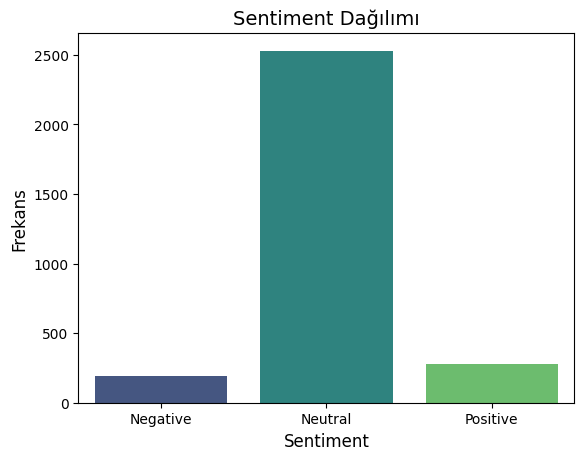

In [13]:
# Sentiment sütunundaki değerlerin dağılımını görselleştirme
def plot_sentiment_distribution(data):
    sentiment_counts = data['sentiment'].value_counts().sort_index()  # Sentiment değerlerinin sayısı
    sentiment_labels = {1: "Positive", 0: "Neutral", -1: "Negative"}  # Etiketler
    
    # Barplot için hazırlık
    sns.barplot(
        x=sentiment_counts.index.map(sentiment_labels.get),  # Etiketleri haritalandır
        y=sentiment_counts.values,
        palette="viridis"
    )
    
    # Grafik başlıkları ve eksen adları
    plt.title("Sentiment Dağılımı", fontsize=14)
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Frekans", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Grafiği göster
    plt.show()

# Sentiment dağılımını çizdirme
plot_sentiment_distribution(data)


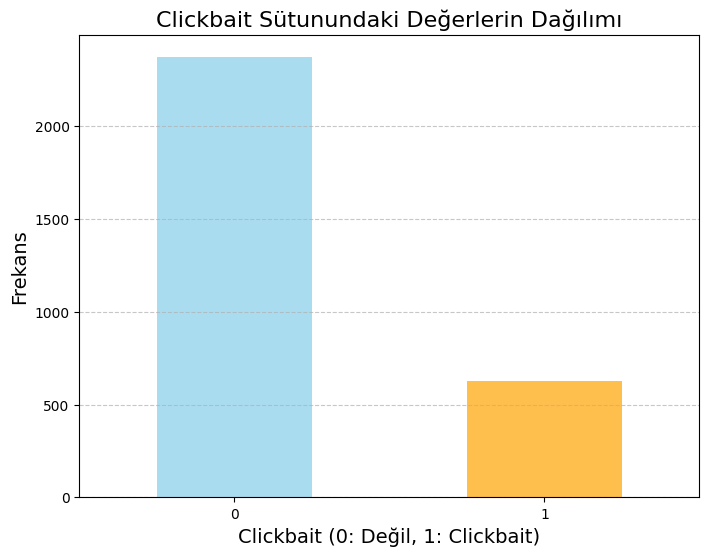

In [14]:
file_path = "/kaggle/input/son-hal-veriseti/veriseti_son_hali.csv"  # Güncellenmiş verisetinin yolu
df = pd.read_csv(file_path)

# Clickbait sütunundaki değerlerin dağılımını hesapla
clickbait_counts = df['clickbait'].value_counts()

# Çubuk grafiği çiz
plt.figure(figsize=(8, 6))
clickbait_counts.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7)
plt.title('Clickbait Sütunundaki Değerlerin Dağılımı', fontsize=16)
plt.xlabel('Clickbait (0: Değil, 1: Clickbait)', fontsize=14)
plt.ylabel('Frekans', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


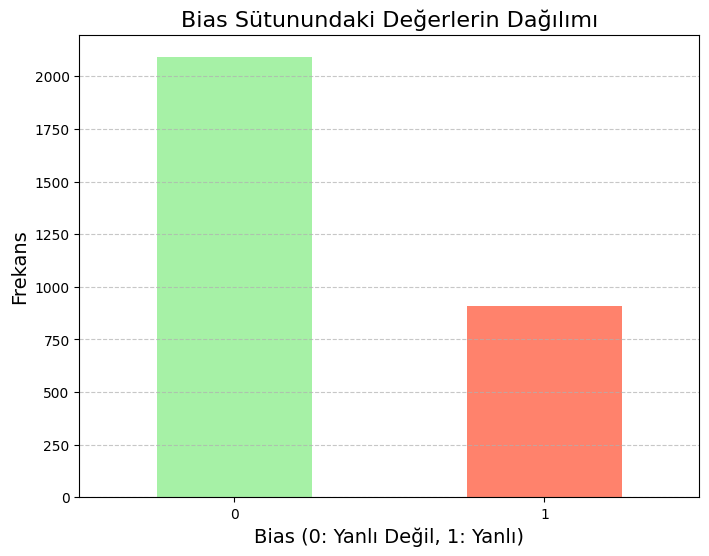

In [37]:
# Veriyi yükle
file_path = "/kaggle/input/verisetinin-sonhalii/veri_seti_son_hali.csv"  # Güncellenmiş verisetinin yolu
df = pd.read_csv(file_path)

# Bias sütunundaki değerlerin dağılımını hesapla
bias_counts = df['bias'].value_counts()

# Çubuk grafiği çiz
plt.figure(figsize=(8, 6))
bias_counts.plot(kind='bar', color=['lightgreen', 'tomato'], alpha=0.8)
plt.title('Bias Sütunundaki Değerlerin Dağılımı', fontsize=16)
plt.xlabel('Bias (0: Yanlı Değil, 1: Yanlı)', fontsize=14)
plt.ylabel('Frekans', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


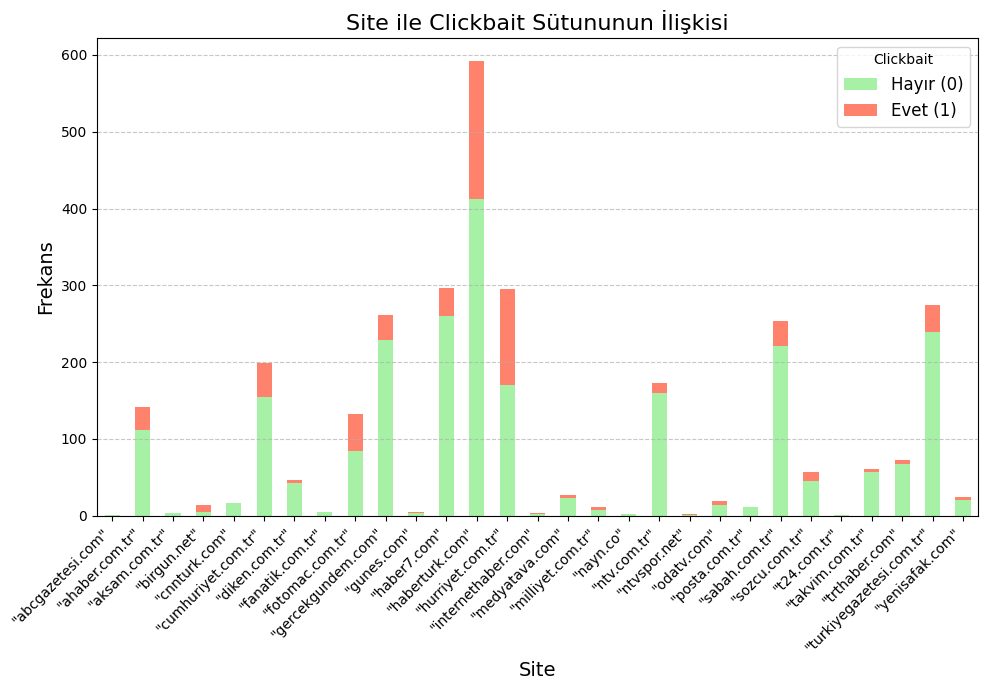

In [41]:
file_path = "/kaggle/input/verisetinin-sonhalii/veri_seti_son_hali.csv"  # Verisetinin yolu
df = pd.read_csv(file_path)

# Site ve Clickbait ilişkisini gruplandırma
site_clickbait = df.groupby(['site', 'clickbait']).size().unstack(fill_value=0)

# Çubuk grafiği çiz
site_clickbait.plot(kind='bar', stacked=True, figsize=(10, 7), color=['lightgreen', 'tomato'], alpha=0.8)
plt.title('Site ile Clickbait Sütununun İlişkisi', fontsize=16)
plt.xlabel('Site', fontsize=14)
plt.ylabel('Frekans', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Clickbait', labels=['Hayır (0)', 'Evet (1)'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Grafik düzenini optimize eder
plt.show()


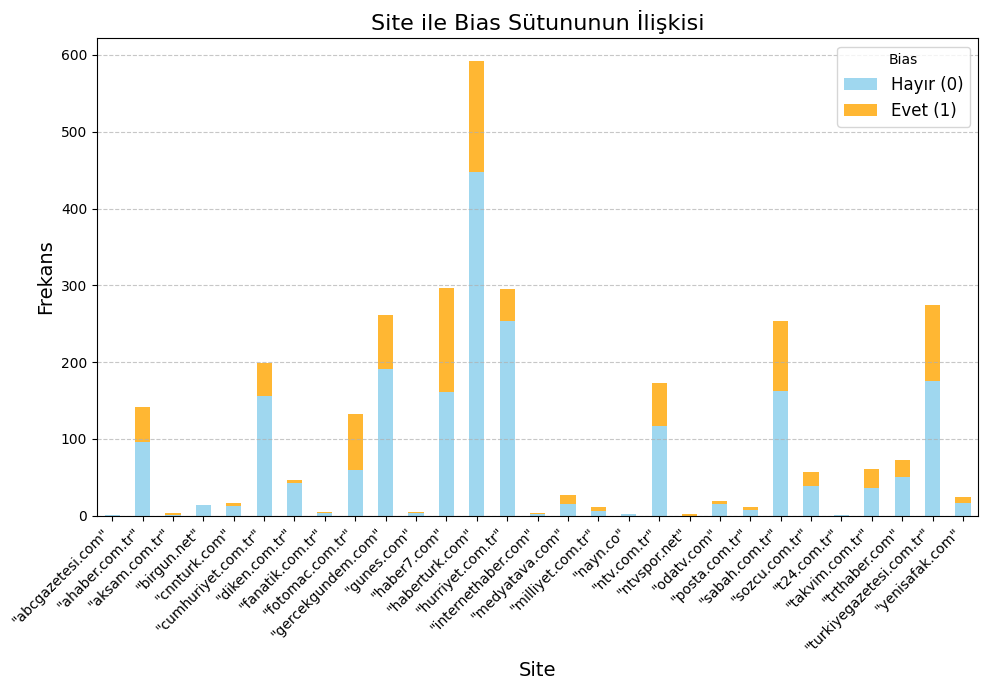

In [40]:
# Veriyi yükle
file_path = "/kaggle/input/verisetinin-sonhalii/veri_seti_son_hali.csv"  # Verisetinin yolu
df = pd.read_csv(file_path)

# Site ve Bias ilişkisini gruplandırma
site_bias = df.groupby(['site', 'bias']).size().unstack(fill_value=0)

# Çubuk grafiği çiz
site_bias.plot(kind='bar', stacked=True, figsize=(10, 7), color=['skyblue', 'orange'], alpha=0.8)
plt.title('Site ile Bias Sütununun İlişkisi', fontsize=16)
plt.xlabel('Site', fontsize=14)
plt.ylabel('Frekans', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Bias', labels=['Hayır (0)', 'Evet (1)'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Grafik düzenini optimize eder
plt.show()
